# Netflix-Sentiment-Classification-Two

# Imports

In [61]:
import os

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# Functions

In [64]:
def check_for_nulls_dupes(df):
  print(f"The amount of NaN values: {df.isna().sum()}")
  print(f"The amount of Duplicated values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_model_performance(df, y, axis):
  fig, ax = plt.subplots(figsize=(15, 8))
  df.plot.bar(x="Model", y=y, ax=ax)
  ax.set_xlabel("Models")
  ax.set_ylabel("Accuracy")
  plt.legend(y)
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()
  
def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  
  filtered_word_tokens = re.sub(f"[^a-zA-z\s]", "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in model_names]

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "KNN": SMOTE(k_neighbors=5),
    "ADASYN": ADASYN()
  }
  
  return [models[model_name] for model_name in model_names]

def create_sampling_pipeline(sampling_model, model):
  steps = [
    ("sample", sampling_model),
    ("model", model)
  ]
  return imbPipeline(steps=steps)

def evaluate_model(X, y, model):
  
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
  metric = make_scorer(f1_score, average="micro")
  scores = cross_val_score(model,X, y, cv=cv, scoring=metric, n_jobs=-1)
  return scores

def tested_selected_models(model_names, models, X, y):
  
  model_performance = []
  
  for i in range(len(model_names)):
    model, model_name = models[i], model_names[i]
    scores = evaluate_model(X, y, model)
    model_performance.append({
      "Model":model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(model_performance_df, ["Mean", "STD"], "Mean")
  print(model_performance_df)

def test_sampling_models(sampling_model_names, sampling_models, model_names, models, X, y):
  
  model_performance = []
  
  for sample_model_name, sample_model in zip(sampling_model_names, sampling_models):
    for model_name, model in zip(model_names, models):
      pipeline = create_sampling_pipeline(sample_model, model)
      scores = evaluate_model(X, y, pipeline)
      model_performance.append({
      "Model":model_name + "-" + sample_model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
    })
  
  performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(performance_df,["Mean", "STD"], "Mean")
  print(performance_df)



# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/netflix_reviews.csv",nrows=10000)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,1772b40f-8cfd-4c56-a370-c944e5b5ce48,Gato Reviews,Utter trash. Been a customer for over 10 years...,1,0,8.114.0 build 19 50680,2024-05-23 22:35:45,8.114.0 build 19 50680
1,b6b64d5c-30f6-4bed-8d66-9b4582e72e3b,Quincy Alleyne,Good,5,0,8.115.2 build 6 50688,2024-05-23 22:34:47,8.115.2 build 6 50688
2,8be7d06b-f90e-4ca7-abf6-f908b40946e2,nez zuber,The only streaming service that beats Netflix ...,2,0,NaN,2024-05-23 22:33:52,NaN
3,72485684-9e73-4dca-a580-0a92b3a3a7e6,Elon Frett,Everything that's objectively good gets remove...,1,0,8.109.0 build 7 50647,2024-05-23 22:30:43,8.109.0 build 7 50647
4,348796c3-0056-4491-80f7-d6c38fcb2790,kwakhanya bambeni,Wish the owner be a trillioner because he/she ...,4,0,NaN,2024-05-23 22:30:27,NaN
...,...,...,...,...,...,...,...,...
9995,260fc52a-ec27-468e-8029-7029391e2dcc,hafiz ejaz,I have used the previous version of the Netfli...,3,836,8.52.2 build 14 50335,2022-12-17 04:34:27,8.52.2 build 14 50335
9996,2ef0eca9-14bf-42f4-b2bb-3836e3ce29eb,Nikolas Mitchell,"I'm disappointed by this recent ""update"" it ma...",1,2,NaN,2023-05-10 11:29:41,NaN
9997,ed5e9c73-0448-4603-a551-8eef04b9730f,William Pearson,A great way to watch some shows and movies! An...,4,274,7.84.1 build 28 35243,2020-12-28 20:03:15,7.84.1 build 28 35243
9998,47441c89-bab5-42b3-b249-a7ce0b43598a,Sorsa,I have limited space on the internal storage o...,2,16,8.30.3 build 14 50239,2023-08-23 15:51:10,8.30.3 build 14 50239


# Check for Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of NaN values: reviewId                  0
userName                  0
content                   2
score                     0
thumbsUpCount             0
reviewCreatedVersion    971
at                        0
appVersion              971
dtype: int64
The amount of Duplicated values: 287


In [5]:
df.dropna(inplace=True)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(8802, 8)

# Check for Class Imabalance

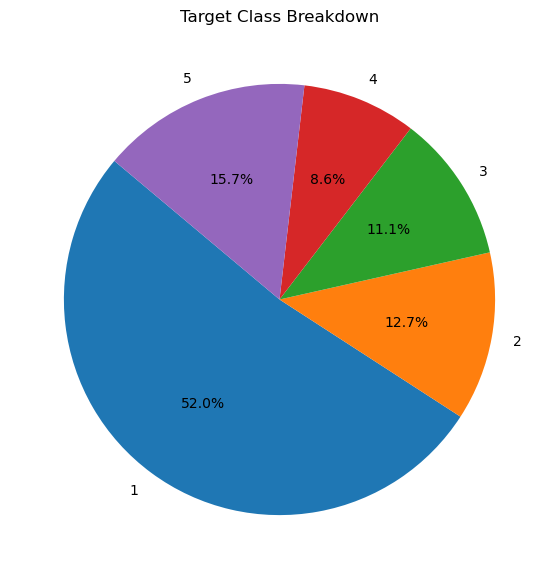

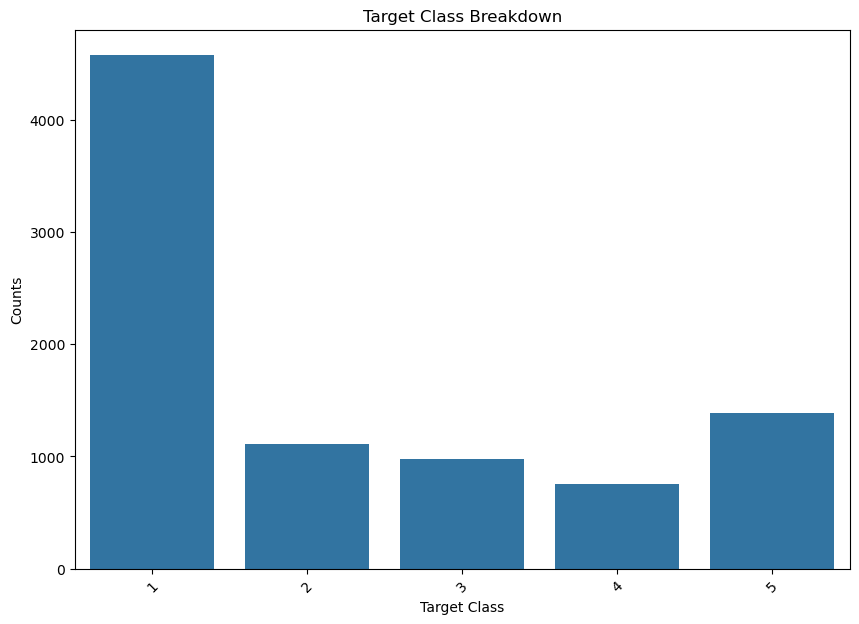

In [8]:
check_class_imbalance(df["score"])

# Skewed Dataset

# Drop Columns we do not need

In [9]:
df.drop(["reviewId", "userName", "reviewCreatedVersion", "appVersion"],axis=1, inplace=True)

# Data Preprocessing

In [12]:

df["content"] = df["content"].apply(lambda x: remove_stop_words(x))
df["score"] = df["score"].apply(lambda x: "postive" if x>=4 else "neg" if x<3 else "neu")
df["at"] = pd.to_datetime(df["at"])

df["day"] = df["at"].dt.day
df["month"] = df["at"].dt.month
df["year"] = df["at"].dt.year
df["hour"] = df["at"].dt.hour

df.drop("at", axis=1, inplace=True)

# Separate Feature Variables

In [13]:
X, y = df.drop("score", axis=1), df["score"]

# Label Encoder

In [16]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

# Create Pipeline

In [39]:
vectorizer = TfidfVectorizer(max_features=250)

tfidf_matrix = vectorizer.fit_transform(X["content"])

tfidf_transformed = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [40]:
tfidf_transformed.shape

(8802, 250)

In [41]:
X.drop("content", axis=1, inplace=True)

In [42]:
tfidf_transformed.index = X.index

X_tfidf = pd.concat([X, tfidf_transformed], axis=1)

In [43]:
pipeline = Pipeline(
  steps=[
    ("scaler", StandardScaler()),
    ("powertransformer", PowerTransformer())
  ]
)

X_processed = pipeline.fit_transform(X_tfidf)

In [44]:
X_processed.shape

(8802, 255)

# Baseline Model Performance

In [56]:
model = DummyClassifier(strategy="uniform")
scores = evaluate_model(X_processed, y_encoded, model)
print(f"Mean Accuracy-Score: {round(np.mean(scores),3)}, STD:{round(np.std(scores),3)}")

Mean Accuracy-Score: 0.334, STD:0.012


# Advanced Model Metrics

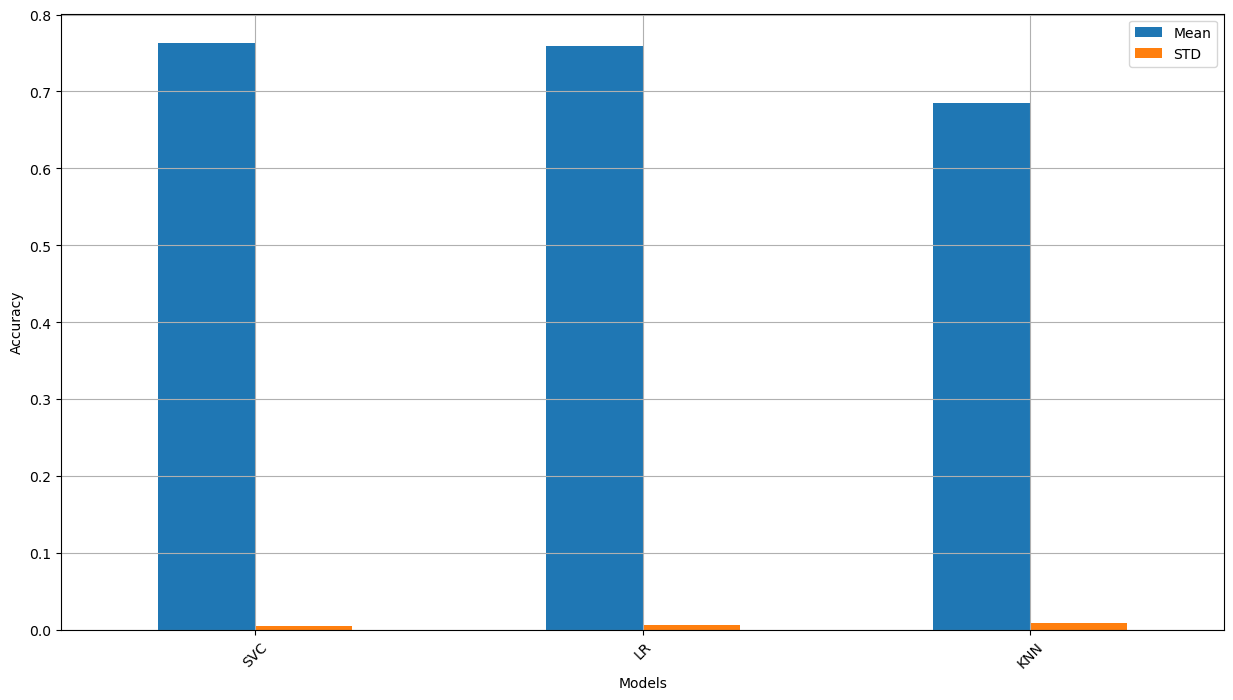

   index Model   Mean    STD
0      1   SVC  0.763  0.005
1      0    LR  0.759  0.006
2      2   KNN  0.685  0.009


In [57]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
tested_selected_models(model_names, models, X_processed, y_encoded)


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


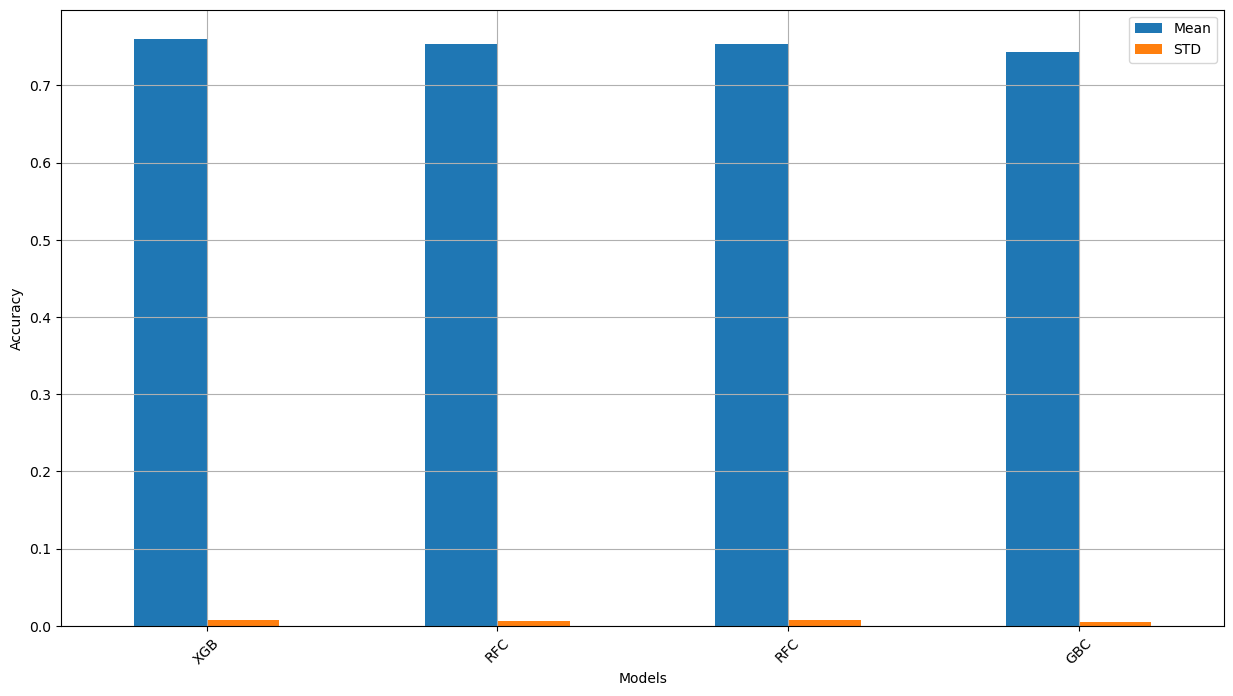

   index Model   Mean    STD
0      2   XGB  0.760  0.008
1      0   RFC  0.754  0.006
2      3   RFC  0.754  0.007
3      1   GBC  0.743  0.005


In [58]:
model_names = ["RFC", "GBC", "XGB", "RFC"]
models = grab_selected_models(model_names)
tested_selected_models(model_names, models, X_processed, y_encoded)

# Model Scores are poor due to the fact of class imbalance. Let's address this with some sampling models.

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


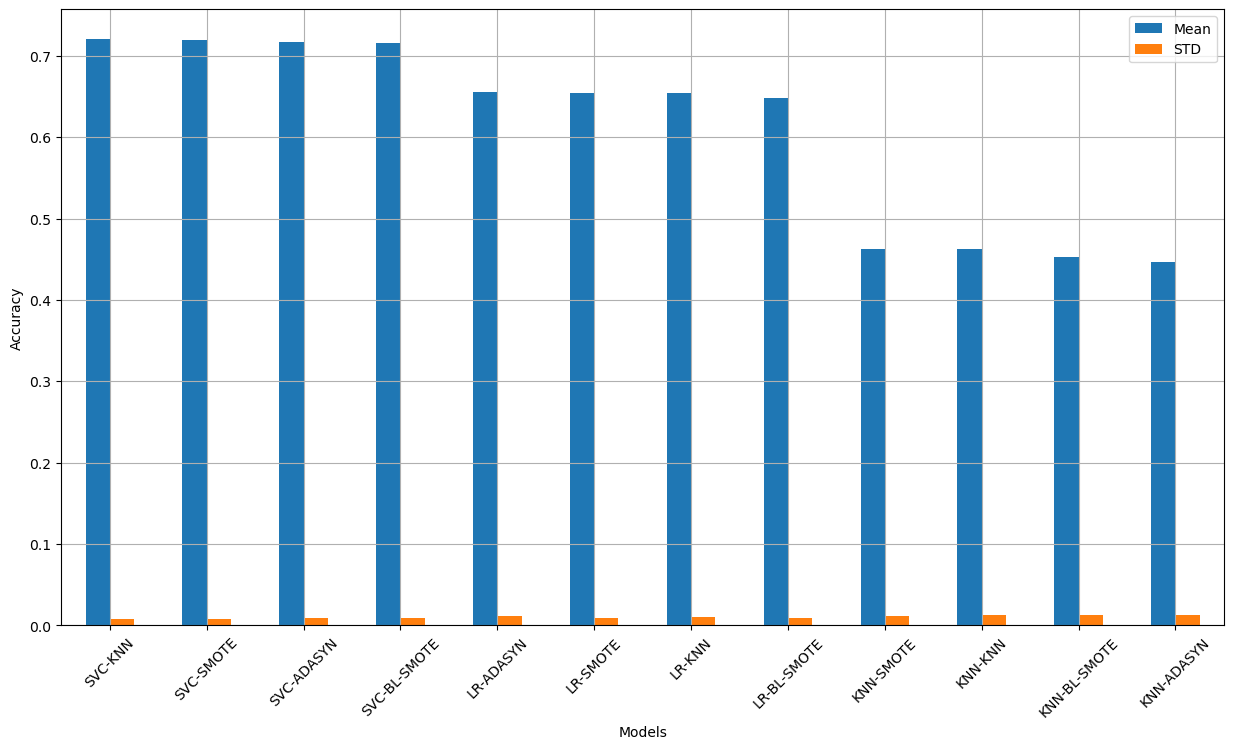

    index         Model   Mean    STD
0       3       SVC-KNN  0.721  0.008
1       0     SVC-SMOTE  0.720  0.008
2       9    SVC-ADASYN  0.717  0.009
3       6  SVC-BL-SMOTE  0.716  0.009
4      10     LR-ADASYN  0.656  0.011
5       1      LR-SMOTE  0.654  0.009
6       4        LR-KNN  0.654  0.010
7       7   LR-BL-SMOTE  0.648  0.009
8       2     KNN-SMOTE  0.463  0.012
9       5       KNN-KNN  0.463  0.013
10      8  KNN-BL-SMOTE  0.453  0.013
11     11    KNN-ADASYN  0.447  0.013


In [65]:
sampling_model_names = ["SMOTE", "KNN", "BL-SMOTE", "ADASYN"]
sampling_models = grab_selected_sampling_models(sampling_model_names)

model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)

test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_processed, y_encoded)